<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/06_normalization_position_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# normalization 위치 조절 실험

## ✅ 실험 목적

BatchNorm의 위치(Conv→BN→ReLU vs Conv→ReLU→BN)가 학습 안정성/성능에 미치는 영향을 비교한다.

동일 조건(데이터/옵티마이저/에폭/모델 용량)에서 위치만 다르게 설정해 수렴 속도와 최종 정확도를 관찰한다.

## 🧪 실험 설계

데이터: CIFAR-10 (32×32 RGB)

공통 전처리: Train = RandomCrop + Flip + Normalize / Test = Normalize

모델: 소형 CNN (두 개의 Conv 블록 + FC)

BN-Before-ReLU: Conv → BN → ReLU

BN-After-ReLU: Conv → ReLU → BN

학습: Adam(lr=1e-3), Epoch=10, Batch=128, Loss=CrossEntropy

평가: Test Accuracy, 학습/검증 정확도 추이 그래프, 최종 성능 바차트, 표 요약

In [ ]:
# =======================
# 0. 라이브러리
# =======================
import torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# =======================
# 1. 데이터셋 & 전처리
# =======================
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
testloader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


- CIFAR-10 사용 (32x32 컬러 이미지, 10개 클래스)

- train_transform

  - RandomCrop, RandomHorizontalFlip → 데이터 증강

  - ToTensor + Normalize → 픽셀 정규화

- test_transform → 정규화만

- DataLoader로 배치 단위 학습/평가 준비

In [ ]:
# =======================
# 2. 블록 정의 (BN 위치 변형)
# =======================
class ConvBlock_BNBeforeReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)          # BN 먼저
        x = self.act(x)         # ReLU 나중
        return x

class ConvBlock_BNAfterReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)         # ReLU 먼저
        x = self.bn(x)          # BN 나중
        return x

# 공통 CNN 골격
class SmallCNN(nn.Module):
    def __init__(self, block_cls):
        super().__init__()
        self.features = nn.Sequential(
            block_cls(3, 32),
            block_cls(32, 32),
            nn.MaxPool2d(2),          # 16x16
            block_cls(32, 64),
            block_cls(64, 64),
            nn.MaxPool2d(2),          # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

BN 위치를 다르게 한 ConvBlock 정의
- BN-Before-ReLU: Conv → BN → ReLU

- BN-After-ReLU: Conv → ReLU → BN

- 실험 목적: BN 위치가 학습/성능에 미치는 영향 비교

공통 CNN 구조 정의
- block_cls로 BN 위치 조절 가능

- ConvBlock 4개 + MaxPool 2개

- FC 2개로 분류

- Flatten 후 FC → 10개 클래스 출력

In [ ]:
# =======================
# 3. 학습/평가 루프
# =======================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    correct, total, run_loss = 0, 0, 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == labels).sum().item()
        total   += labels.size(0)
    return run_loss / len(loader), correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    correct, total, run_loss = 0, 0, 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        run_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == labels).sum().item()
        total   += labels.size(0)
    return run_loss / len(loader), correct / total

def run_experiment(block_cls, epochs=10, lr=1e-3):
    model = SmallCNN(block_cls).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    hist = {"train_acc": [], "train_loss": [], "test_acc": [], "test_loss": []}
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, trainloader, optimizer, criterion)
        te_loss, te_acc = evaluate(model, testloader, criterion)
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["test_loss"].append(te_loss);  hist["test_acc"].append(te_acc)
        print(f"[Epoch {ep:02d}] train_acc={tr_acc*100:.2f}%  test_acc={te_acc*100:.2f}%")
    return model, hist

학습/평가 루프
- train_one_epoch: 한 epoch 학습

- evaluate: test/validation 평가

- 정확도 계산: argmax → 정답과 비교

실험 실행 함수
- 지정한 BN 위치(block_cls)로 학습/평가

- 정확도/손실 기록(hist dictionary)

- Epoch마다 print로 진행상황 출력

In [ ]:
# =======================
# 4. 두 구조 비교 실행
# =======================
print("\n=== BN Before ReLU ===")
model_before, hist_before = run_experiment(ConvBlock_BNBeforeReLU, epochs=10, lr=1e-3)

print("\n=== BN After ReLU ===")
model_after,  hist_after  = run_experiment(ConvBlock_BNAfterReLU,  epochs=10, lr=1e-3)


=== BN Before ReLU ===
[Epoch 01] train_acc=46.95%  test_acc=60.96%
[Epoch 02] train_acc=62.95%  test_acc=66.24%
[Epoch 03] train_acc=68.83%  test_acc=67.52%
[Epoch 04] train_acc=71.84%  test_acc=74.94%
[Epoch 05] train_acc=73.67%  test_acc=71.24%
[Epoch 06] train_acc=75.34%  test_acc=75.31%
[Epoch 07] train_acc=76.65%  test_acc=77.26%
[Epoch 08] train_acc=78.14%  test_acc=79.46%
[Epoch 09] train_acc=78.71%  test_acc=77.93%
[Epoch 10] train_acc=79.52%  test_acc=78.70%

=== BN After ReLU ===
[Epoch 01] train_acc=51.45%  test_acc=65.15%
[Epoch 02] train_acc=67.27%  test_acc=72.13%
[Epoch 03] train_acc=72.29%  test_acc=75.69%
[Epoch 04] train_acc=75.67%  test_acc=77.97%
[Epoch 05] train_acc=77.93%  test_acc=79.72%
[Epoch 06] train_acc=79.26%  test_acc=80.68%
[Epoch 07] train_acc=80.44%  test_acc=80.77%
[Epoch 08] train_acc=81.68%  test_acc=81.39%
[Epoch 09] train_acc=82.52%  test_acc=81.45%
[Epoch 10] train_acc=83.22%  test_acc=82.16%


- BN 위치에 따른 모델 학습/평가

- 결과 저장(hist_before, hist_after)

In [ ]:
# =======================
# 5. 표 요약 출력
# =======================
summary = pd.DataFrame([
    {"Model": "BN-Before-ReLU", "Final Train Acc (%)": f"{hist_before['train_acc'][-1]*100:.2f}",
     "Final Test Acc (%)": f"{hist_before['test_acc'][-1]*100:.2f}"},
    {"Model": "BN-After-ReLU",  "Final Train Acc (%)": f"{hist_after['train_acc'][-1]*100:.2f}",
     "Final Test Acc (%)": f"{hist_after['test_acc'][-1]*100:.2f}"},
])
print("\n=== Summary (Final Epoch) ===")
print(summary)


=== Summary (Final Epoch) ===
            Model Final Train Acc (%) Final Test Acc (%)
0  BN-Before-ReLU               79.52              78.70
1   BN-After-ReLU               83.22              82.16


- 최종 epoch 기준 train/test accuracy 출력

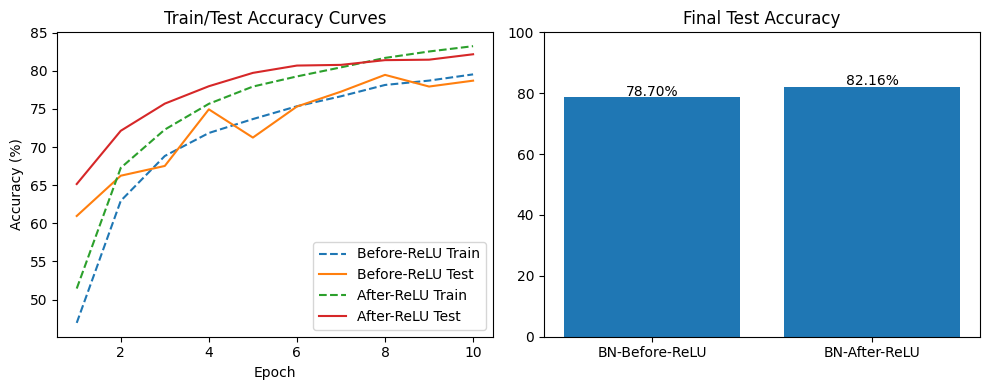

In [ ]:
# =======================
# 6. 시각화 (Accuracy curves + Bar)
# =======================
epochs = range(1, len(hist_before["train_acc"])+1)

plt.figure(figsize=(10,4))
# (a) Train/Test Accuracy curves
plt.subplot(1,2,1)
plt.plot(epochs, np.array(hist_before["train_acc"])*100, label="Before-ReLU Train", linestyle="--")
plt.plot(epochs, np.array(hist_before["test_acc"])*100,  label="Before-ReLU Test")
plt.plot(epochs, np.array(hist_after["train_acc"])*100,  label="After-ReLU Train", linestyle="--")
plt.plot(epochs, np.array(hist_after["test_acc"])*100,   label="After-ReLU Test")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Train/Test Accuracy Curves")
plt.legend()

# (b) Final Test Accuracy bar
plt.subplot(1,2,2)
finals = [hist_before["test_acc"][-1]*100, hist_after["test_acc"][-1]*100]
plt.bar(["BN-Before-ReLU", "BN-After-ReLU"], finals)
for i,v in enumerate(finals):
    plt.text(i, v+0.5, f"{v:.2f}%", ha="center")
plt.ylim(0, 100)
plt.title("Final Test Accuracy")
plt.tight_layout()
plt.show()

## 📝 결론: Normalization 위치 조절 실험

1. BN-Before-ReLU (Conv → BN → ReLU)

  - 최종 Train Acc: 79.52%

  - 최종 Test Acc: 78.70%

2. BN-After-ReLU (Conv → ReLU → BN)

  - 최종 Train Acc: 83.22%

  - 최종 Test Acc: 82.16%

👉 비교해보면, Batch Normalization을 ReLU 뒤에 두었을 때가 앞에 둘 때보다 Train/Test 정확도가 모두 더 높게 나타났음.

## ✅ 결론 요약

- BN 위치는 성능에 영향을 준다.

- 이번 실험에서는 BN을 ReLU 뒤에 적용하는 것이 더 효과적이었다.

- 이는 ReLU로 인해 발생하는 음수 값 제거(비선형성 반영) 이후에 분포를 정규화하는 것이 학습 안정성과 일반화에 유리했기 때문으로 해석할 수 있음.

- 따라서 모델 설계 시, BN의 위치를 고민할 필요가 있으며 Activation 뒤에서 BN을 적용하는 방식이 더 좋은 선택일 수 있다.